<a href="https://colab.research.google.com/github/knowfix/Tumor-Detection-with-MobilenetV2-InceptionV3/blob/main/MRI_Tumor_Detection_with_MobilenetV2_%26_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **AHMAD TAUFIQ (MRI Tumor Detection with MobilenetV2 and InceptionV3 Architecture)**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import json
import zipfile,os
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
! pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [5]:
!touch ~/.kaggle/kaggle.json

In [6]:
api_token = {"username":"priyova","key":"ccb2975c38f82e4f0ccf8512f693c23e"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

100% 86.8M/86.8M [00:04<00:00, 25.4MB/s]
100% 86.8M/86.8M [00:04<00:00, 20.7MB/s]


In [9]:
local_zip = '/content/brain-tumor-classification-mri.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Preprocessing Data

## Import Data Train

In [10]:
train_dir = '/content/Training'
os.listdir(train_dir)

['meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'glioma_tumor']

In [11]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(train_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        file_name.append(name)

In [12]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
pituitary_tumor     827
dtype: int64

In [13]:
image_size = 224
batch_size = 192

# Create an ImageDataGenerator for the training dataset with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Create a training data generator
train_data = train_datagen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(image_size, image_size),
    class_mode="categorical",
    subset="training"  # Use this subset for training
)

# Create a validation data generator
validation_data = train_datagen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=False,  # Set to False for validation
    target_size=(image_size, image_size),
    class_mode="categorical",
    subset="validation"  # Use this subset for validation
)


# Check the number of samples in training and validation sets
print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(validation_data))

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Number of training samples: 12
Number of validation samples: 3


## Import Data Test

In [14]:
# Assuming you have defined 'image_size' and the paths to your testing dataset
test_dir = "/content/Testing"

# Create an ImageDataGenerator for the testing dataset
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

# Flow from directory for the testing dataset
test_data = test_datagen.flow_from_directory(
    batch_size=batch_size,  # Use the same batch size as during training
    directory=test_dir,
    shuffle=False,  # Set to False to keep the order of predictions
    target_size=(image_size, image_size),
    class_mode="categorical"
)

Found 394 images belonging to 4 classes.


In [15]:
batch_data, batch_labels = next(train_data)

# Mengecek shape dan ndim
print("Shape of batch data:", batch_data.shape)
print("Number of dimensions (ndim):", batch_data.ndim)


Shape of batch data: (192, 224, 224, 3)
Number of dimensions (ndim): 4


# Showing the Data

## Train Images

In [16]:
label_dict=train_data.class_indices
classes=list(label_dict.keys())
images,labels=next(train_data)

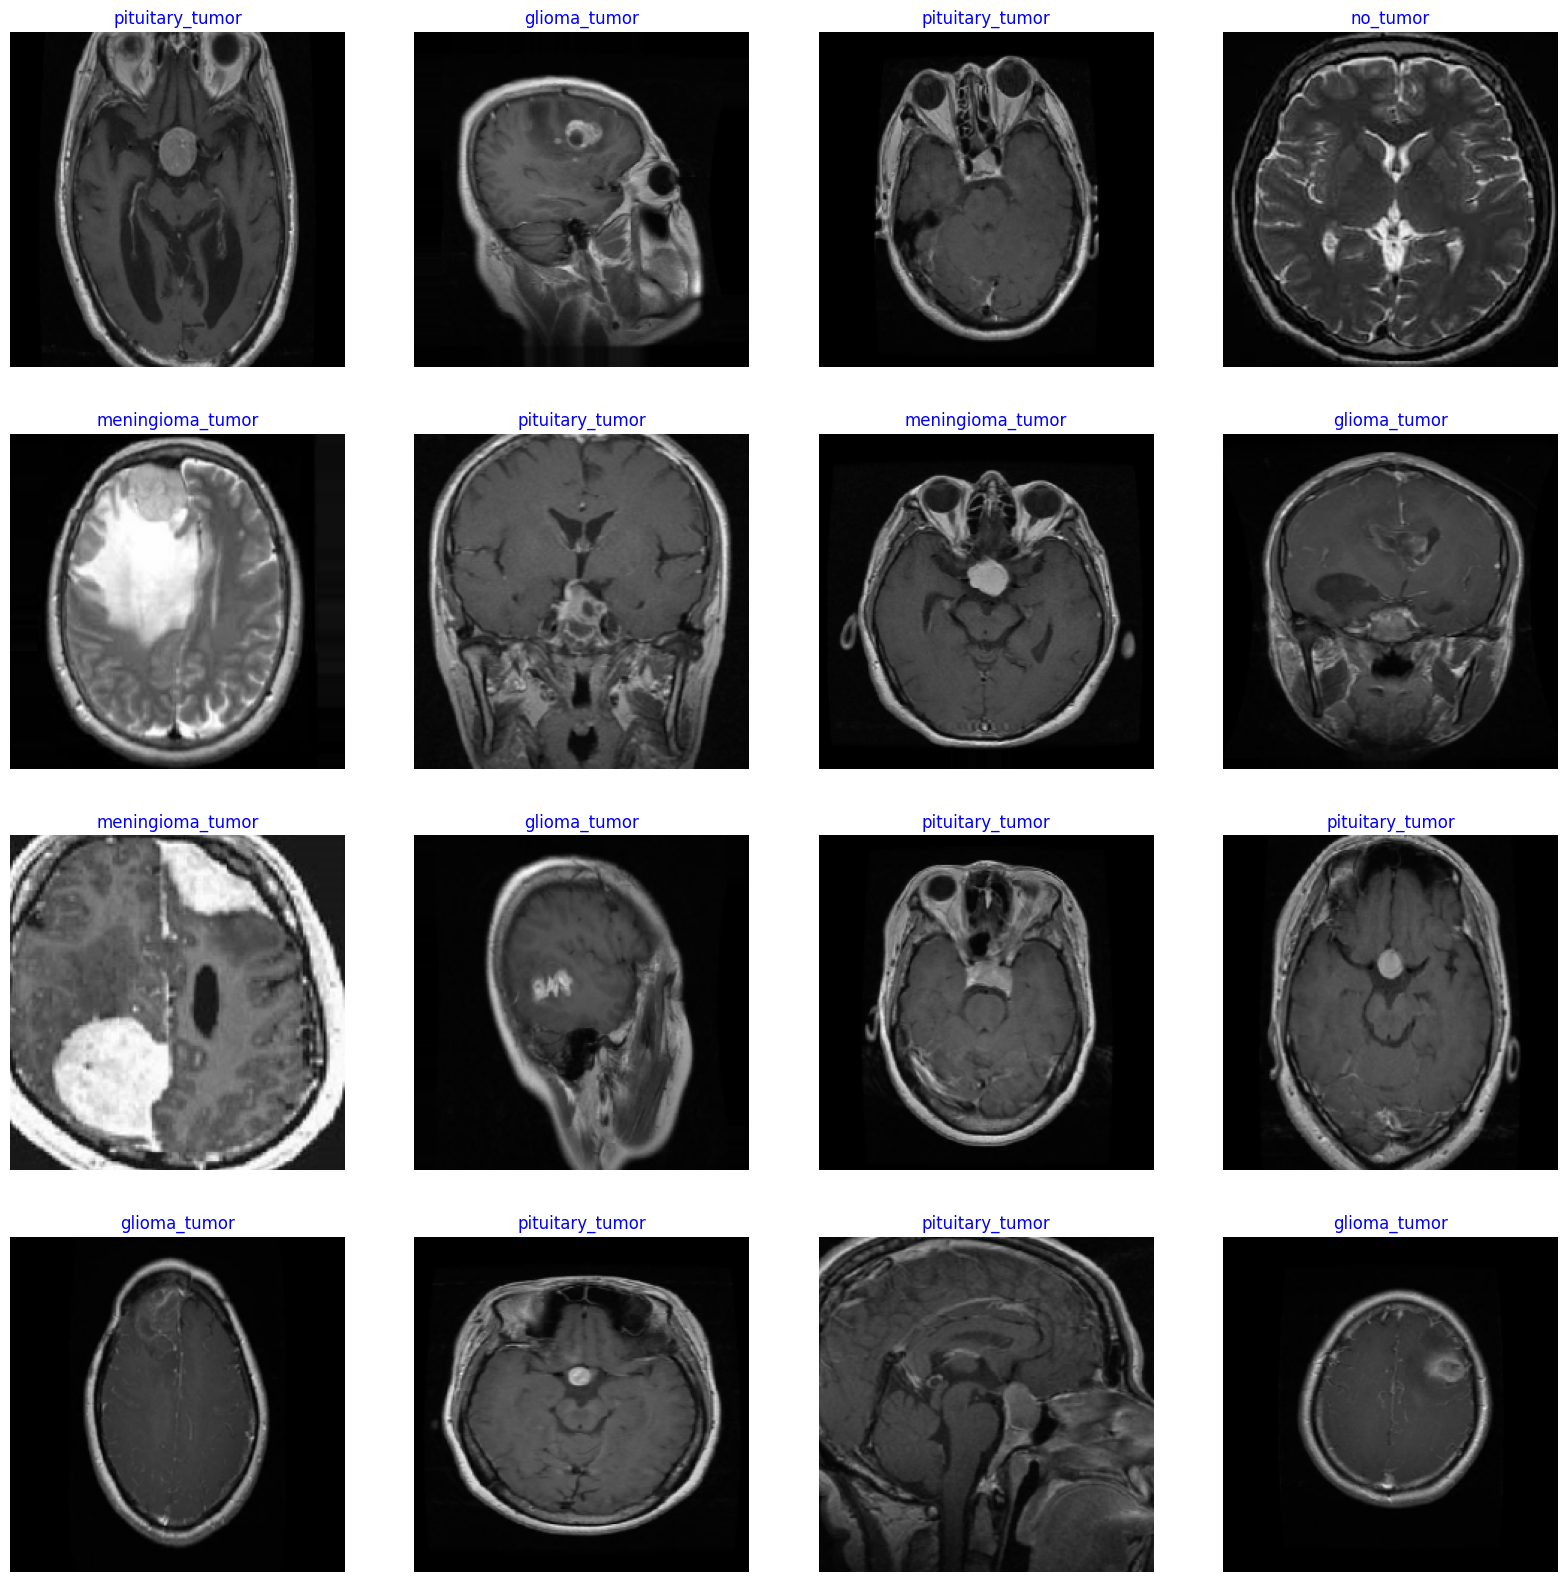

In [17]:
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

## Test Images

In [18]:
label_test=test_data.class_indices
classes_test=list(label_test.keys())
images_test,labels_test=next(test_data)

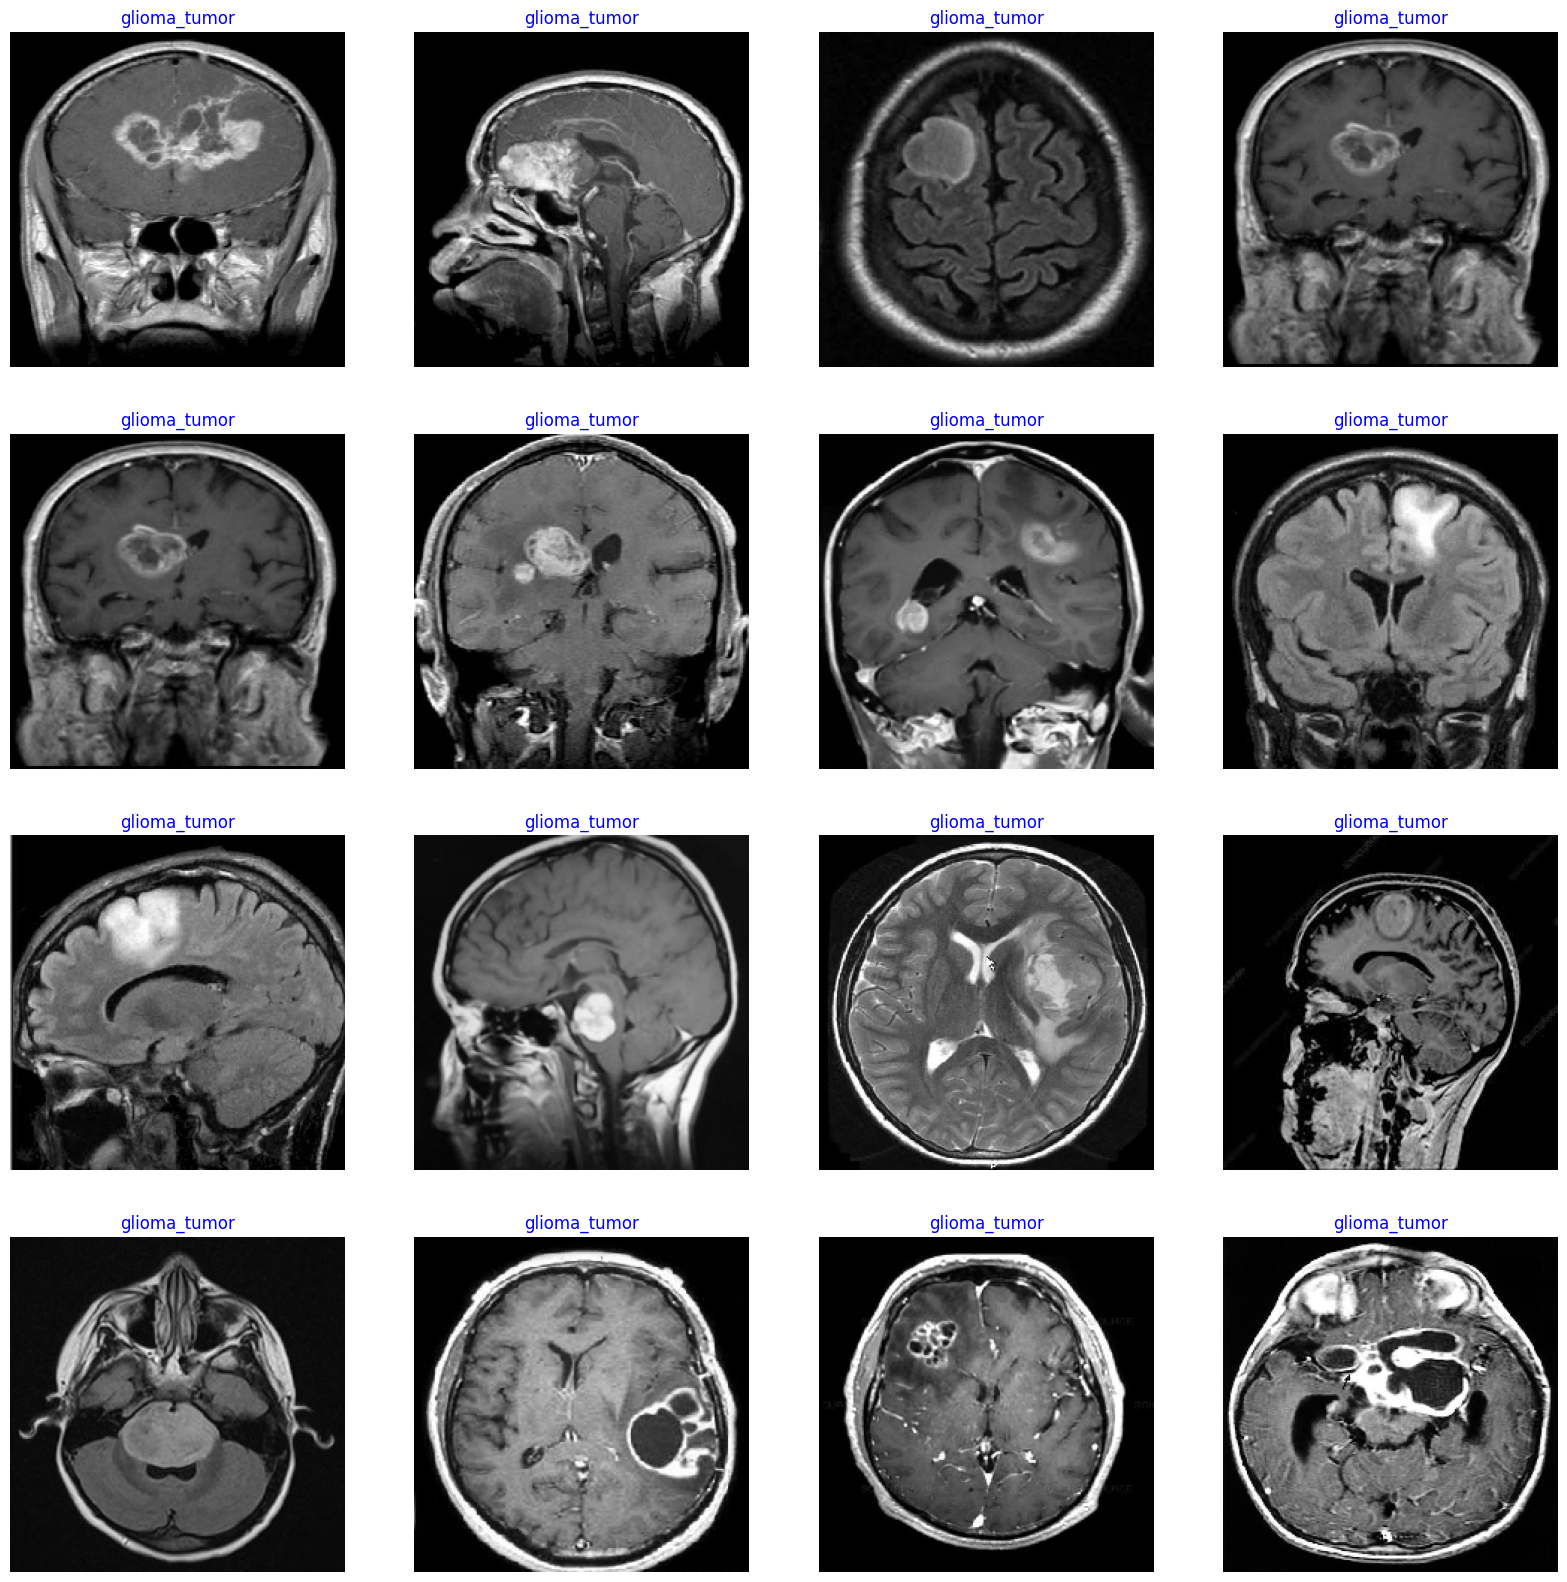

In [19]:
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images_test[i]
    plt.imshow(image)
    index = np.argmax(labels_test[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

# MobilenetV2

In [20]:
# Load pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

# Combine the base model and additional layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Set up optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.categorical_crossentropy
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Print model summary
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [21]:
model_checkpoint_filpath5 = "model_checkpoint.h5"
callbacks_checkpoints5 = tf.keras.callbacks.ModelCheckpoint(
    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [22]:
history = model.fit(train_data,
                    epochs = 20,
                    validation_data = validation_data,
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/20
12/12 [==============================] - 51s 4s/step - loss: 1.6939 - accuracy: 0.4806 - val_loss: 0.9351 - val_accuracy: 0.6545
Epoch 2/20
12/12 [==============================] - 37s 3s/step - loss: 0.7411 - accuracy: 0.7109 - val_loss: 0.7097 - val_accuracy: 0.7155
Epoch 3/20
12/12 [==============================] - 37s 3s/step - loss: 0.5356 - accuracy: 0.7941 - val_loss: 0.5980 - val_accuracy: 0.7679
Epoch 4/20
12/12 [==============================] - 37s 3s/step - loss: 0.4895 - accuracy: 0.8076 - val_loss: 0.5933 - val_accuracy: 0.7382
Epoch 5/20
12/12 [==============================] - 35s 3s/step - loss: 0.4467 - accuracy: 0.8306 - val_loss: 0.6109 - val_accuracy: 0.7504
Epoch 6/20
12/12 [==============================] - 36s 3s/step - loss: 0.4122 - accuracy: 0.8398 - val_loss: 0.5812 - val_accuracy: 0.7609
Epoch 7/20
12/12 [==============================] - 35s 3s/step - loss: 0.3989 - accuracy: 0.8515 - val_loss: 0.5748 - val_accuracy: 0.7749
Epoch 8/20
12/12 [==

In [23]:
def make_plot(train, valid, title):
  graph = plt.plot(history.history[train])
  graph = plt.plot(history.history[valid])
  graph = plt.title(title)
  graph = plt.legend(['training', 'accuracy'])
  graph = plt.show()
  return graph

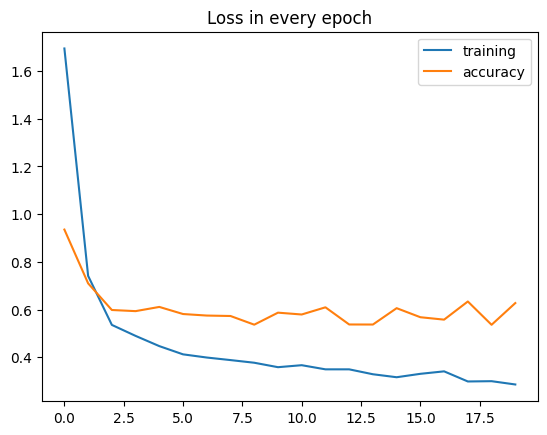

In [24]:
make_plot('loss','val_loss', "Loss in every epoch")

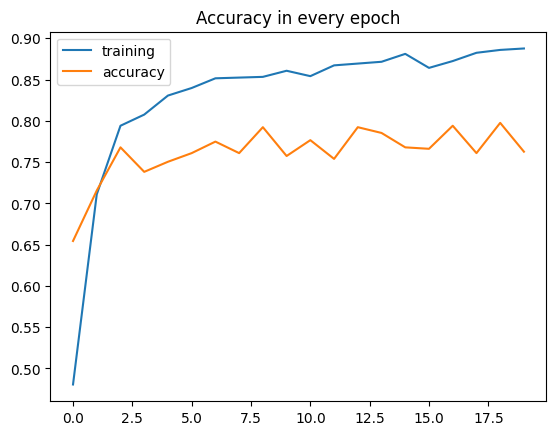

In [25]:
make_plot('accuracy','val_accuracy', "Accuracy in every epoch")

## Predicted Label

In [26]:
def get_class(index):
  for class_string, class_index in test_data.class_indices.items():
    if class_index == index:
      return class_string

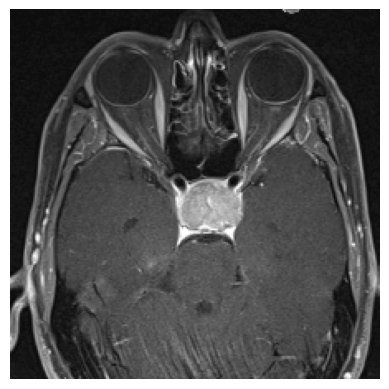

1/1 [==============================] - 0s 24ms/step
True Label:  pituitary_tumor
Predicted Label:  pituitary_tumor


In [28]:
a,b = next(test_data)
image = a[0,:,:,:]
plt.imshow(image)
plt.axis('off')
plt.show()

true_index = np.argmax(b[0])


prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print('True Label: ', get_class(true_index))
print('Predicted Label: ', get_class(predicted_index))

# Incepiton V3

In [29]:
# Load pre-trained MobileNetV2 model
from tensorflow.keras.applications import InceptionV3
insep = InceptionV3(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

for layer in insep.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 4s 0us/step


In [30]:
y = insep.output
# y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(y)
y = tf.keras.layers.BatchNormalization()(y)

y = tf.keras.layers.Dropout(0.2, name='top_dropout')(y)
y = tf.keras.layers.Dense(1024, activation='relu')(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dropout(0.5)(y)
# y = tf.keras.layers.Dense(512, activation='relu')(y)
predictions2 = tf.keras.layers.Dense(4, activation='softmax')(y)

mymodel = tf.keras.Model(inputs=insep.input, outputs=predictions2)


In [31]:
mymodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [32]:
# Set up optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.categorical_crossentropy
metrics = ['accuracy']

# Compile the model
mymodel.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, monitor='val_loss')

In [34]:
history2 = mymodel.fit(train_data,
                    epochs = 20,
                    validation_data = validation_data,
                    callbacks = [es]
                    )

Epoch 1/20
12/12 [==============================] - 75s 5s/step - loss: 1.3819 - accuracy: 0.6748 - val_loss: 1.0777 - val_accuracy: 0.6056
Epoch 2/20
12/12 [==============================] - 40s 3s/step - loss: 0.6687 - accuracy: 0.8185 - val_loss: 0.9826 - val_accuracy: 0.6335
Epoch 3/20
12/12 [==============================] - 37s 3s/step - loss: 0.4521 - accuracy: 0.8585 - val_loss: 0.9590 - val_accuracy: 0.6283
Epoch 4/20
12/12 [==============================] - 38s 3s/step - loss: 0.3160 - accuracy: 0.8925 - val_loss: 0.8364 - val_accuracy: 0.7120
Epoch 5/20
12/12 [==============================] - 37s 3s/step - loss: 0.2740 - accuracy: 0.9007 - val_loss: 0.8813 - val_accuracy: 0.6789
Epoch 6/20
12/12 [==============================] - 38s 3s/step - loss: 0.2423 - accuracy: 0.9142 - val_loss: 0.7123 - val_accuracy: 0.7365
Epoch 7/20
12/12 [==============================] - 37s 3s/step - loss: 0.2070 - accuracy: 0.9238 - val_loss: 0.7256 - val_accuracy: 0.7173
Epoch 8/20
12/12 [==

In [37]:
def make_plot(train, valid, title):
  graph = plt.plot(history2.history[train])
  graph = plt.plot(history2.history[valid])
  graph = plt.title(title)
  graph = plt.legend(['training', 'validation'])
  graph = plt.show()
  return graph

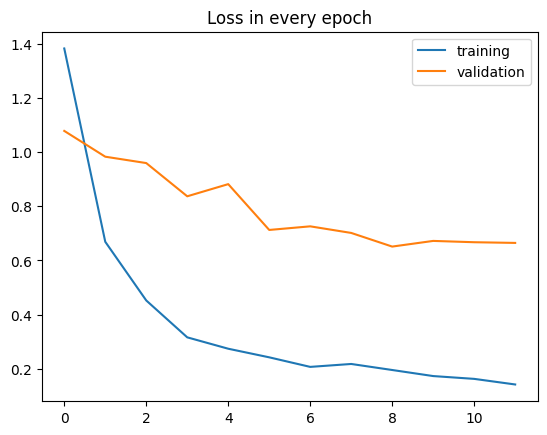

In [38]:
make_plot('loss','val_loss', "Loss in every epoch")

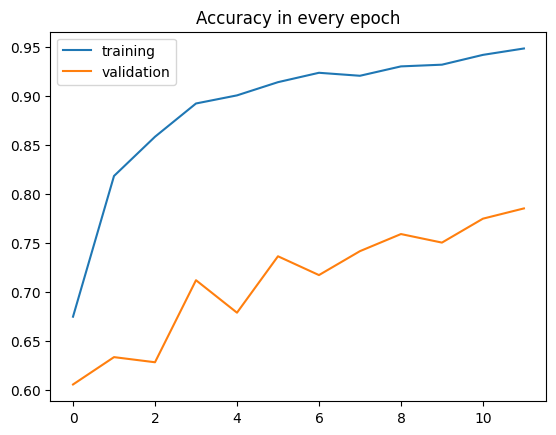

In [39]:
make_plot('accuracy','val_accuracy', "Accuracy in every epoch")

## Predicted Label

In [40]:
def get_class(index):
  for class_string, class_index in test_data.class_indices.items():
    if class_index == index:
      return class_string

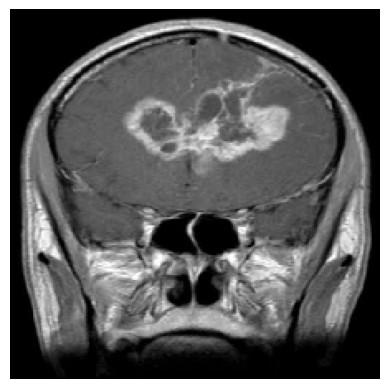

1/1 [==============================] - 3s 3s/step
True Label:  glioma_tumor
Predicted Label:  pituitary_tumor


In [41]:
a,b = next(test_data)
image = a[0,:,:,:]
plt.imshow(image)
plt.axis('off')
plt.show()

true_index = np.argmax(b[0])


prediction_scores = mymodel.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print('True Label: ', get_class(true_index))
print('Predicted Label: ', get_class(predicted_index))

# **NEW MODEL COMBINE MOBILNETV2 AND INCEPTIONV3**

In [42]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D

def conv2d_bn(x, filters, kernel_size, strides=1, padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [43]:
from tensorflow.keras.layers import concatenate

def inception_block(x, filters):
    branch1x1 = Conv2D(filters[0], (1, 1), activation='relu')(x)

    branch3x3 = Conv2D(filters[1], (1, 1), activation='relu')(x)
    branch3x3 = Conv2D(filters[2], (3, 3), activation='relu', padding='same')(branch3x3)

    branch5x5 = Conv2D(filters[3], (1, 1), activation='relu')(x)
    branch5x5 = Conv2D(filters[4], (5, 5), activation='relu', padding='same')(branch5x5)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), activation='relu')(branch_pool)

    x = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=3)
    return x

In [44]:
# Load pre-trained MobileNetV2 model
base_model_new = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model_new.layers:
    layer.trainable = False

# Add additional layers
x = base_model_new.output
# x = tf.keras.layers.Reshape((1, 1, 1280))(x)  # Reshape to 4D tensor
x = inception_block(x, [64, 128, 128, 128, 192, 32])  # Contoh filter untuk blok Inception
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l= 0.016), activation='relu')(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l= 0.016), activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

# Combine the base model and additional layers
model = tf.keras.Model(inputs=base_model_new.input, outputs=predictions)

# Set up optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.categorical_crossentropy
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, monitor='val_loss')

In [46]:
history = model.fit(train_data,
                    epochs = 20,
                    validation_data = validation_data,
                    callbacks = [es]
                    )

Epoch 1/20
12/12 [==============================] - 45s 3s/step - loss: 18.7079 - accuracy: 0.4240 - val_loss: 14.8260 - val_accuracy: 0.5567
Epoch 2/20
12/12 [==============================] - 37s 3s/step - loss: 12.0177 - accuracy: 0.6979 - val_loss: 9.3546 - val_accuracy: 0.7016
Epoch 3/20
12/12 [==============================] - 37s 3s/step - loss: 7.5577 - accuracy: 0.7758 - val_loss: 5.9765 - val_accuracy: 0.7243
Epoch 4/20
12/12 [==============================] - 36s 3s/step - loss: 4.7380 - accuracy: 0.8337 - val_loss: 3.9263 - val_accuracy: 0.7469
Epoch 5/20
12/12 [==============================] - 36s 3s/step - loss: 3.0529 - accuracy: 0.8420 - val_loss: 2.5942 - val_accuracy: 0.7976
Epoch 6/20
12/12 [==============================] - 36s 3s/step - loss: 2.0367 - accuracy: 0.8642 - val_loss: 1.9494 - val_accuracy: 0.7958
Epoch 7/20
12/12 [==============================] - 37s 3s/step - loss: 1.4607 - accuracy: 0.8724 - val_loss: 1.4464 - val_accuracy: 0.7923
Epoch 8/20
12/12 

In [47]:
def make_plot(train, valid, title):
  graph = plt.plot(history.history[train])
  graph = plt.plot(history.history[valid])
  graph = plt.title(title)
  graph = plt.legend(['training', 'validation'])
  graph = plt.show()
  return graph

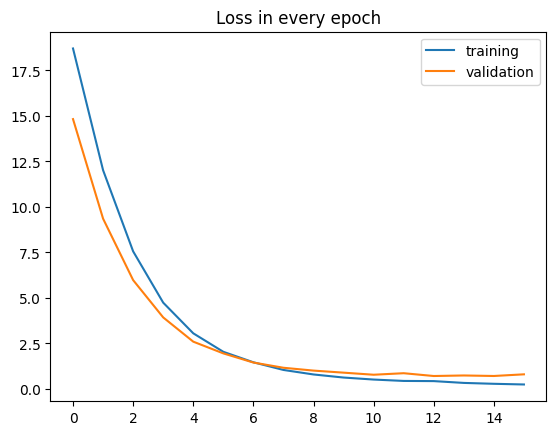

In [48]:
make_plot('loss','val_loss', "Loss in every epoch")

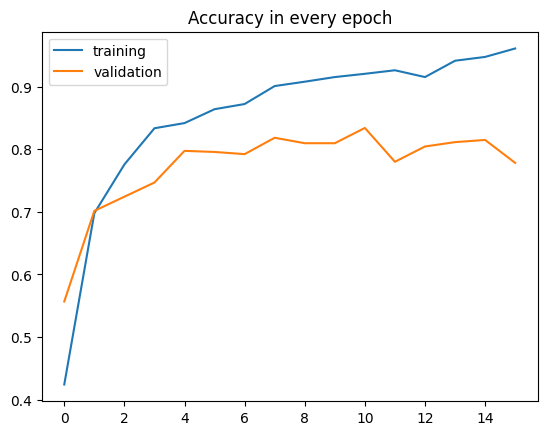

In [49]:
make_plot('accuracy','val_accuracy', "Accuracy in every epoch")

## **TESTING WITH OTHER IMAGE**

Saving image(82).jpg to image(82) (1).jpg
1/1 [==============================] - 1s 1s/step

===== PREDICTING RESULT ======
image(82) (1).jpg
no_tumor


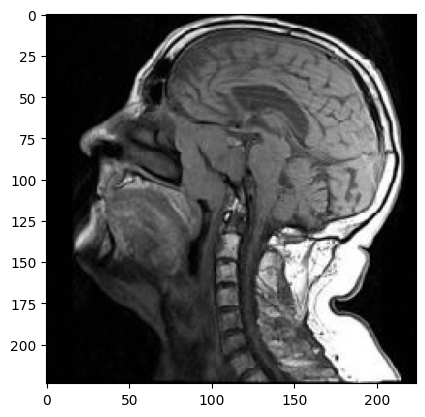

In [51]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  predict = np.argmax(classes)
  print('\n===== PREDICTING RESULT ======')
  print(fn)
  for key, value in train_data.class_indices.items():
    if value == predict :
      print(key)